
## Introduction


This is the python implementation of the paper "ASIA: Automated Social Identity Assessment using linguistic style".

This tutorial is aimed at readers who have a basic familiarity with Python. You can find the original version of this tutorial at https://github.com/Identity-lab/Tutorial-on-salient-social-Identity-detection-model.
<br>
<br>
<br>



In order to run the code, first you need to

- download the datasets (Mumsnet_feminist_parent.csv, Reddit_feminist_parent.csv)
- copy the datasets in a folder named data

<br>



Each of these csv files contains posts from both parent and feminist forums. 


<br>
<br>


## Reading the datasets

In [1]:
# path to data
DBDIR = './data/'
# path to where the model would be saved
SAVEDIR = './save_dir'

# datasets
Mumsnet_DB = 'Mumsnet_feminist_parent.csv'

# all LIWC stylistic features
ALL_STYLISTIC_FEATURES = ['WPS', 'i', 'we', 'you', 'shehe', 'they', 'ipron','article', 'auxverb', 'past',
                    'present', 'future', 'adverb', 'preps','conj', 'quant', 'number', 'time', 'Sixltr',
                    'Period', 'Colon', 'SemiC', 'QMark', 'Dash', 'Quote', 'Apostro', 'Parenth', 'OtherP',
                    'negate', 'swear', 'posemo','negemo', 'assent', 'nonfl', 'filler', 'Exclam', 'insight',
                    'cause', 'discrep', 'tentat', 'certain', 'inhib', 'incl', 'excl']

Here we considered all the stylistic LIWC features for training our identity detection model, however, any subset of these features can be considered. 


<br>

First, we read our dataset:


In [2]:
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler


def read_csv(path):
    try:
        df = pd.read_csv(path)
    except:
        print('error in reading file')
        raise
    return df



In [3]:
mumsnet_df = read_csv(DBDIR + Mumsnet_DB)
print('mumsnet features:%s'%list(mumsnet_df))
print(mumsnet_df.shape)

mumsnet features:['msg_id', 'user_id', 'forum_id', 'WC', 'WPS', 'Sixltr', 'Dic', 'funct', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'verb', 'auxverb', 'past', 'present', 'future', 'adverb', 'preps', 'conj', 'negate', 'quant', 'number', 'swear', 'social', 'family', 'friend', 'humans', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'cogmech', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'inhib', 'incl', 'excl', 'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'relativ', 'motion', 'space', 'time', 'work', 'achieve', 'leisure', 'home', 'money', 'relig', 'death', 'assent', 'nonfl', 'filler', 'dummy', 'Period', 'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote', 'Apostro', 'Parenth', 'OtherP', 'AllPct']
(622350, 84)


Then, we filter the short posts (posts with less than a specific word numbers) - this step is optional.


In [4]:
def preprocessing(df, min_WC):
    df = df.dropna()
    df = df.loc[df['WC'] >= min_WC]
    return df

In [5]:
min_WC = 25

mumsnet_df = preprocessing(mumsnet_df, min_WC)
print(mumsnet_df.shape)


(461371, 84)


### Buiding the train set and the test set

We train our model on posts from mumsnet data, and later on, we would apply our trained model on data from Reddit.

<br>

So, let's first build the train and test sets from mumsnet data. 
- The training set containes 100,000 posts randomly drawn from muments data, 50,000 posts from each forums, feminist and parent. We call that between samples. 
- Test set on the other hand, contains posts written by those who are contributing in both forums (one per each forum), we call that within samples. 

<br>

For this, we first need to separate individuals who are posting in both forums from those who are contributing only in one of the forums (we call them between and within participants).



In [6]:
def separating_users(df):
    fem_df = df.loc[df.forum_id == 1]
    par_df = df.loc[df.forum_id == 0]
    
    # participants who are posting in both forums
    within_p = set(fem_df.user_id.unique()).intersection(par_df.user_id.unique())
    # participants who are posting only in one forum, parent or feminist
    between_p = df[~df.user_id.isin(within_p)].user_id.unique()

    return between_p, within_p

In [7]:
between_p, within_p = separating_users(mumsnet_df)
print('number of between participants:%s'%len(between_p))
print('number of within participants:%s'%len(within_p))

number of between participants:15698
number of within participants:2333


<br>
Well, as it is mentioned, we extract the training set from all the posts, 50000 from each forums:

In [8]:
def get_train_set(df, batch_size):
    # shuffle the rows
    df = df.sample(frac=1)

    # buiding train set by randomly selecting posts from feminist and parent forums
    posts_fem = df[df['forum_id'] == 1][:batch_size]
    posts_par = df[df['forum_id'] == 0][:batch_size]
    
    trainDB = pd.concat([posts_fem, posts_par])
    
    return trainDB

In [9]:
trainDB = get_train_set(mumsnet_df, batch_size=50000)
print('\ntrain set size:{}'.format(trainDB.shape[0]))


train set size:100000


<br>
Test posts then would be sampled from within posts, but from those within participants whose their posts are not among the training posts:

In [10]:
mumsnet_df_rest = mumsnet_df.loc[~mumsnet_df.msg_id.isin(trainDB.msg_id)].copy(deep=True)
mumsnet_df_rest.shape

(361371, 84)

In [11]:
between_p, within_p = separating_users(mumsnet_df_rest)
print('remaining number of between participants:%s'%len(between_p))
print('remaining number of within participants:%s'%len(within_p))

remaining number of between participants:14578
remaining number of within participants:1943


In [12]:
within_posts = mumsnet_df_rest.loc[mumsnet_df_rest.user_id.isin(within_p)]
within_posts.shape

(101909, 84)

<br>
Now we have the within posts, we randomly select one post per forum from each within participant:

In [13]:
def extract_testcases(posts_within, no=None):
    # randomly selecting one post per forum for each within participant
    testDB = posts_within.sample(frac=1)
    testDB = testDB.drop_duplicates(subset=['user_id', 'forum_id'])

    # if there is a limit on the number of test cases, we extract the test cases from 
    # no randomly choosen within participants
    if no is not None:
        within_participants = posts_within.user_id.unique()
        testUsers = np.random.choice(within_participants, no, replace=False)
        testDB = testDB.loc[testDB['user_id'].isin(testUsers)]

    return testDB

In [14]:
testDB = extract_testcases(within_posts)
testDB.shape

(3886, 84)


<br>

## Training our model



Here we apply Logistic regression for training our model. If grid_search is true, best parameter would be chosen for the model, but it takes longer to train the model. 

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score
import joblib


def Logistic_Regression(grid_search=False):
    # to add the regularization, you can set penalty=‘l1’ or penalty=‘l2’ (depending on the solver).
    model = LogisticRegression(solver='lbfgs', max_iter = 2000, penalty='none')
    
    
    if grid_search:
        tuned_parameters = [{'C': [1e-3, 1e-2, 1e-1, 1]}]
        model = GridSearchCV(LogisticRegression(solver='lbfgs'), tuned_parameters, cv=10,
                           scoring='accuracy', n_jobs=-1)

    return model


def train(X_train, y_train, cross_val=True, save_dir=SAVEDIR):
    
    
    model = Logistic_Regression()

    # training accuracy and AUC
    tr_auc, tr_acc = None, None
    if cross_val:
        tr_auc = np.mean(cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc'))
        tr_acc = np.mean(cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy'))
        
        print('training accuracy:{}'.format(tr_acc), 'training AUC :{}'.format(tr_auc))

    model.fit(X_train, y_train)

    joblib.dump(model, save_dir+'/logr.sav')

    print('\n our model is trained and saved in %s'%save_dir+'/logr.sav')

    return model, tr_auc, tr_acc

In [16]:
X_train, y_train = trainDB[ALL_STYLISTIC_FEATURES], trainDB['forum_id']

In [17]:
model, tr_auc, tr_acc = train(X_train, y_train, cross_val=False, save_dir=SAVEDIR)



 our model is trained and saved in ./save_dir/logr.sav



<br>

## Testing our model



Via cross validation we get an estimate of how well our model is performing when it comes to the between posts.Now, in order to do the proper test, we apply ourtrained model on the within posts:

In [18]:
def test(model, X_test, y_test):
    y_pred = model.predict(X_test)
    ts_acc = accuracy_score(y_test, y_pred)

    s = model.decision_function(X_test)
    ts_auc = roc_auc_score(y_test, s)

    print('test accuracy:{}'.format(ts_acc), 'test AUC :{}'.format(ts_auc))
    


In [19]:
X_test, y_test = testDB[ALL_STYLISTIC_FEATURES], testDB['forum_id']

In [20]:
test(model, X_test, y_test)

test accuracy:0.7035512094698919 test AUC :0.7651500603006582



<br>

Now we know how accurate our model is, let's get a little bit deeper into the results:


In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt 

predict_abs = model.predict(X_test)


tn, fp, fn, tp = confusion_matrix(y_test, predict_abs).ravel()

print('Out of %s test samples from parent forum, %s have been correctly predicted as parent post, \n'
      'and %s have been falsely predicted as feminist post.\n'%(int(X_test.shape[0]/2), tn, fp))


print('Out of %s test samples from feminist forum, %s have been correctly predicted as feminist post, \n'
      'and %s have been falsely predicted as parent post.'%(int(X_test.shape[0]/2), tp, fn))


Out of 1943 test samples from parent forum, 1270 have been correctly predicted as parent post, 
and 673 have been falsely predicted as feminist post.

Out of 1943 test samples from feminist forum, 1464 have been correctly predicted as feminist post, 
and 479 have been falsely predicted as parent post.


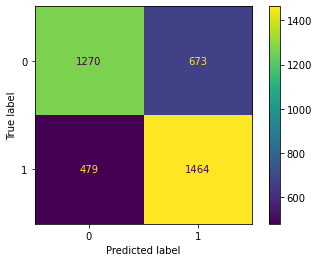

In [22]:
plot_confusion_matrix(model, X_test, y_test) 
plt.show()


In [23]:
print('false positive error rate - rate of predicting a parent post as a feminist post:', fp / (fp + tn))
print('false negative error rate - rate of predicting a feminist post as a parent post:', fn / (fn + tp))

false positive error rate - rate of predicting a parent post as a feminist post: 0.34637159032424086
false negative error rate - rate of predicting a feminist post as a parent post: 0.2465259907359753


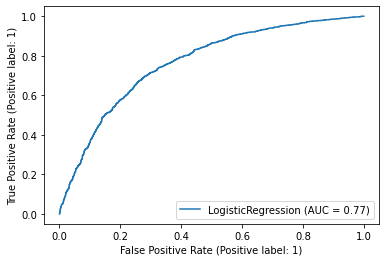

In [24]:
plot_roc_curve(model, X_test, y_test)
plt.show()


<br>

### What does that mean?

In [25]:
coefficients = dict(list(zip(ALL_STYLISTIC_FEATURES, model.coef_[0])))

In [26]:
coefficients

{'WPS': -0.0014058447286483314,
 'i': 0.022067618957219235,
 'we': -0.06302959121977386,
 'you': -0.042157089935516014,
 'shehe': -0.11395341229718954,
 'they': 0.17792374113235637,
 'ipron': 0.17454144347784512,
 'article': 0.1145123056175375,
 'auxverb': 0.057563657621676756,
 'past': -0.05494724051779543,
 'present': -0.06952223079311094,
 'future': -0.09300924795556068,
 'adverb': -0.03945879295252902,
 'preps': 0.029760965168349023,
 'conj': 0.03446752954219318,
 'quant': 0.05272767790151019,
 'number': 0.03539637933260117,
 'time': -0.22860832361476902,
 'Sixltr': 0.14527561515648704,
 'Period': -0.016346919445075568,
 'Colon': 0.018198784558206907,
 'SemiC': 0.03344789777478542,
 'QMark': -0.022651548788606608,
 'Dash': 0.001338846071622425,
 'Quote': 0.299385565445758,
 'Apostro': 0.012951816591063557,
 'Parenth': -0.008250319017476028,
 'OtherP': -0.04793507382427383,
 'negate': 0.12882764047694348,
 'swear': 0.15963991012358675,
 'posemo': -0.057375804138106404,
 'negemo': 0.

<br>

Now, we want to see how important each stylistic LIWC feature is in identifying parent vs feminist identities:

In [27]:
Xtrain_std = X_train.std(axis=0, skipna=True)
Xtrain_std = dict(list(zip(ALL_STYLISTIC_FEATURES, Xtrain_std)))

In [28]:
feature_importance = {feature:coefficients[feature] * Xtrain_std[feature] for feature in ALL_STYLISTIC_FEATURES}
feature_importance

{'WPS': -0.03522161981706688,
 'i': 0.07152714998075084,
 'we': -0.0821486630295828,
 'you': -0.09734950320719112,
 'shehe': -0.3078233290659499,
 'they': 0.28931773643924347,
 'ipron': 0.5839588736743431,
 'article': 0.3338707119278019,
 'auxverb': 0.2120818965083884,
 'past': -0.16804130764276662,
 'present': -0.29119392645279113,
 'future': -0.1320288932594474,
 'adverb': -0.12399550594599416,
 'preps': 0.11324373210983166,
 'conj': 0.10264706470870684,
 'quant': 0.1212156935385333,
 'number': 0.03806163192899925,
 'time': -0.890867432935723,
 'Sixltr': 0.8409986495083144,
 'Period': -0.08451906464047969,
 'Colon': 0.011953636979002423,
 'SemiC': 0.01015045401510059,
 'QMark': -0.03592716564269259,
 'Dash': 0.003086243950692611,
 'Quote': 0.46787803686037965,
 'Apostro': 0.03838459115594936,
 'Parenth': -0.00794392376199532,
 'OtherP': -0.09626829735475656,
 'negate': 0.2496814391408723,
 'swear': 0.09752066713158195,
 'posemo': -0.16293259742464572,
 'negemo': 0.10050899068357541,


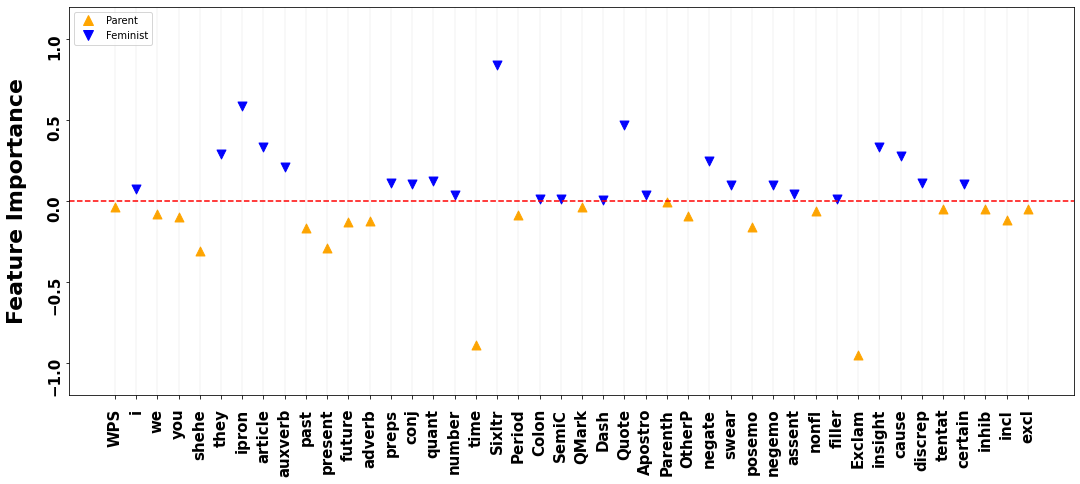

In [29]:
import matplotlib.lines as mlines


plt.figure(figsize=(15, 7))
axes = plt.gca()
axes.set_ylim([-1.2, 1.2])
axes.set_position([0.06, 0.1999999999999999, 0.93, 0.77])

x_pos = np.arange(len(ALL_STYLISTIC_FEATURES))

for x, y in list(zip(x_pos, feature_importance.values())):
    if y > 0:
        axes.scatter(x, y, marker='v', c='blue', s=80)
    else:
        axes.scatter(x, y, marker='^', c='orange', s=80)
plt.xticks(x_pos, ALL_STYLISTIC_FEATURES)
orange_triangle = mlines.Line2D([], [], color='orange', marker='^', linestyle='None',
                                markersize=10, label='Feminist')
blue_triangle = mlines.Line2D([], [], color='blue', marker='v', linestyle='None',
                              markersize=10, label='parent')

axes.legend((orange_triangle, blue_triangle), ('Parent', 'Feminist'), loc='upper left')

plt.axhline(y=0.0, color='r', linestyle='--')

plt.xticks(rotation=90)
axes.tick_params(axis='x', pad=10)
plt.yticks(rotation=90)
for tick in axes.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
for tick in axes.yaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.ylabel('Feature Importance', fontsize=22, labelpad=20, fontweight='bold')

plt.grid(b=True, axis='x', color='gray', linestyle='-', linewidth=0.1)
plt.savefig(SAVEDIR+'/featureimportance.png')
plt.show()
